# Autotrader - Used Car Price analysis

## ~tldr
There are 3 'types' of car:
- 'New' (Registration >2017) (or milage <20k): High depreciation is the cost of having latest car
- 'Used' (2017 >= Registration >= 2010): Middling depreciation, relatively constant year on year
- 'Older' (2010 >= Registration >= 2010): Lower depreciation, relatively constant year on year
    
Additional costs per 10HP above 125HP

year | Additional Costs
--- | ---
2017+ | £440 per 10HP
2010-2017 | £280 per 10HP
<2010 | £230 per 10HP


Make-specific schedule of depreciation (approximate) for car running 7500 miles per year:

year | Ford Focus | Peugeot 308 | Seat Leon | Volkswagen Golf 
--- | --- | --- | --- | ---
2017+ | £2630 / yr | - | £1770 / yr | £2600 / yr
2010-2017 | £885 / yr | - | £1120 / yr | £1335 / yr
<2010 | £400 / yr | £300 / yr | £400 / yr | £600 / yr

Make-specific base price (approximate) for 'undepreciated' model, runnign 7500 miles a year with 125HP engine:

year | Ford Focus | Peugeot 308 | Seat Leon | Volkswagen Golf 
--- | --- | --- | --- | ---
2017+ | £18820 | - | £17360 | £21040
2010-2017 | £12920 | - | £15370 | £15860
<2010 | £7120 | £4990  | £7240 | £10550

## caveat emptor
Large cohort effect:
- in pricing of a recognised '201x model'
- in the difference between 09/59 reg and 10/60 reg
- Not possible to disentangle with this dataset
- Mostly perception driven

Possible Multi-collinearity in mixed classes regression given that age-if-class is going to be correlated with age

# Gathering data

Ended up just saving html rather than fixing proxy setttings to not get blocked

In [6]:
import requests
from bs4 import BeautifulSoup
from IPython.display import Markdown
markdown=lambda s: display(Markdown(s))

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.linear_model import Ridge

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.api import anova_lm


In [7]:
postcode='SE50DF'
car_make='FORD'
car_model='FOCUS'
body_type='Hatchback'
transmission='Manual'
fuel_type='Petrol'
year_from=2014
year_to=2017
colours='%2C'.join(['Silver','Grey'])
min_engine_size=1.4
max_engine_size=1.6


searchUrl='https://www.autotrader.co.uk/car-search?postcode={0}&make={1}&model={2}&include-delivery-option=on&'\
            +'body-type={3}&transmission={4}&fuel-type={5}&year-from={6}&year-to={7}&colour={8}&'\
            +'minimum-badge-engine-size={9}&maximum-badge-engine-size={10}&onesearchad=Used&onesearchad=Nearly%20New&'\
            +'onesearchad=New&advertising-location=at_cars'.format(postcode,
                                                                   car_make,
                                                                   car_model,
                                                                   body_type,
                                                                   transmission,
                                                                   fuel_type,
                                                                   year_from,
                                                                   year_to,
                                                                   colours,
                                                                   min_engine_size,
                                                                   max_engine_size)


In [8]:
import glob
import re
import pandas as pd

In [9]:
from os import getcwd
print(getcwd())

C:\Users\Mille\Documents\GitHub\millerdw.github.io\_notebooks\IllustratingThePoint_6


In [10]:
def regex_next(listing_specifications,pattern):
    return next((det.text for det in listing_specifications if re.search(pattern,det.text)), None)

def format_listing(html_listing,car_make,car_model):
#     print(html_listing)
    listing_specs_dict=dict()
    listing_specs_dict['make']=car_make
    listing_specs_dict['model']=car_model
    
    #<span class="listings-standout">featured listing</span>
    
    listing_thumbnails = html_listing.find('div',{'class':'product-card-image__thumbnails'})
    if listing_thumbnails is not None: 
        listing_thumbnails=listing_thumbnails.findAll('img')
        listing_specs_dict['thumbnails']=' '.join([img['src'] for img in listing_thumbnails])
    
    listing_price = html_listing.find('div',{'class':'product-card-pricing__price'})
    if listing_price is not None: 
        listing_price=int(listing_price.find('span').text[2:].replace(',',''))
        listing_specs_dict['price']=listing_price

    listing_specifications = html_listing.find('ul',{'class':'listing-key-specs'})
    if listing_specifications is not None:
        listing_specifications = listing_specifications.findAll('li')
#         print([spec.text for spec in listing_specifications])
        listing_specs_dict['reg_year']=regex_next(listing_specifications,r'\([:0-9:][:0-9:] reg\)')
        listing_specs_dict['body_type']=regex_next(listing_specifications,r'[Hatchback|Estate]')
        listing_specs_dict['mileage']=regex_next(listing_specifications,r' miles')
        listing_specs_dict['engine_size']=regex_next(listing_specifications,r'[:0-9:]\.[:0-9:]L')
        listing_specs_dict['engine_power']=regex_next(listing_specifications,r'[:0-9:]+[BHP|HP|PS]')
        listing_specs_dict['gearbox']=regex_next(listing_specifications,r'[Manual|Automatic]')
        listing_specs_dict['fuel_type']=regex_next(listing_specifications,r'[Petrol|Diesel|Hybrid]')
        listing_specs_dict['gearbox']=regex_next(listing_specifications,r'[Manual|Automatic]')
        listing_specs_dict['owners']=regex_next(listing_specifications,r' owner')
        listing_specs_dict['emissions']=regex_next(listing_specifications,r'ULEZ')
        listing_specs_dict['history']=regex_next(listing_specifications,r' history')
        
    listing_details = html_listing.find('h3',{'class':'product-card-details__title'})
    if listing_details is not None:
#         print(listing_details.text.split(' '))
        listing_details = listing_details.text.split(' ')
        listing_specs_dict['details']=' '.join(listing_details)
        listing_specs_dict['doors']=next((det for det in listing_details if re.search(r'[ |^][:0-9:][d|dr|drs][ |$]',det)), None)
    
    return listing_specs_dict

In [93]:
car_makes_models=[('ford','focus'),('volkswagen','golf'),('peugeot','308'),('seat','leon')]

listings = []
for car_make,car_model in car_makes_models:
    for file in glob.glob('./web_pages/{0}_{1}_*.htm*'.format(car_make,car_model)):
        with open(file) as html_doc:
            soup = BeautifulSoup(html_doc, 'html.parser')
            html_listings = soup.findAll("div", {"class": "product-card__inner"})
            for html_listing in html_listings:
                listings.append(format_listing(html_listing,car_make,car_model))
                
listings = pd.DataFrame(listings)

listings['year']=[float(l.split(' ')[0])+0.5*(int(l.split(' ')[1][1:3])>=50) if l is not None else None for l in listings['reg_year']]
listings['miles']=[float(l.replace(',','').split(' ')[0]) if l is not None else None for l in listings['mileage']]
listings['age']=2020.5-listings['year']
listings['engine']=[float(l[:-1]) for l in listings['engine_size']]

listings['power']=[float(l.replace('BHP','').replace('PS',''))*(0.986 if re.search(r'PS',l) else 1.) if l is not None else None for l in listings['engine_power']]
print("Median Horse Power {0}".format(listings['power'].median()))
listings['power_above_med']=listings['power']-125

listings['miles_per_year']=listings['miles']/listings['age']
print("Median Miles per year".format(listings['miles_per_year'].median()))
listings['miles_per_year_above_med']=listings['miles_per_year']-7.5e3

listings['is_new']=(listings['age']==0.)
listings['is_used_newer']=(listings['year']>2017)&(listings['age']>0.)
listings['is_used_medium']=(listings['year']<=2017)&(listings['year']>=2010)
listings['is_used_older']=(listings['year']<2010)

for car_make,car_model in car_makes_models:
    listings['is_{0}_{1}'.format(car_make,car_model)]=(listings['make']==car_make) & (listings['model']==car_model)
    
listings.head()

Median Horse Power 123.0
Median Miles per year


,make,model,thumbnails,price,reg_year,body_type,mileage,engine_size,engine_power,gearbox,...,is_new,is_used_newer,is_used_older,is_ford_focus,is_volkswagen_golf,is_peugeot_308,is_seat_leon,is_used_medium,miles_per_year_above_med,power_above_med
0,ford,focus,ford_focus_1_files/af3b2316ddd04623b72d3da3d7e...,12450,2017 (67 reg),2017 (67 reg),"20,148 miles",1.5L,148BHP,Hatchback,...,False,True,False,True,False,False,False,False,-784.000000,23.0
1,ford,focus,ford_focus_1_files/cda25c8af8ed4bb78e1c1072f35...,12590,2017 (67 reg),2017 (67 reg),"16,500 miles",1.5L,150PS,Hatchback,...,False,True,False,True,False,False,False,False,-2000.000000,22.9
2,ford,focus,ford_focus_1_files/3af89d38cef442c9b13e20499c4...,10000,2015 (15 reg),2015 (15 reg),"5,432 miles",1.5L,150PS,Hatchback,...,False,False,False,True,False,False,False,True,-6512.363636,22.9
3,ford,focus,NaN,11750,2017 (17 reg),2017 (17 reg),"19,612 miles",1.5L,150PS,Hatchback,...,False,False,False,True,False,False,False,True,-1896.571429,22.9
4,ford,focus,ford_focus_1_files/20341eea7d2e46ba9a0d0b97775...,5490,2014 (14 reg),2014 (14 reg),"64,000 miles",1.6L,104BHP,Hatchback,...,False,False,False,True,False,False,False,True,2346.153846,-21.0


# Simple Visualisations

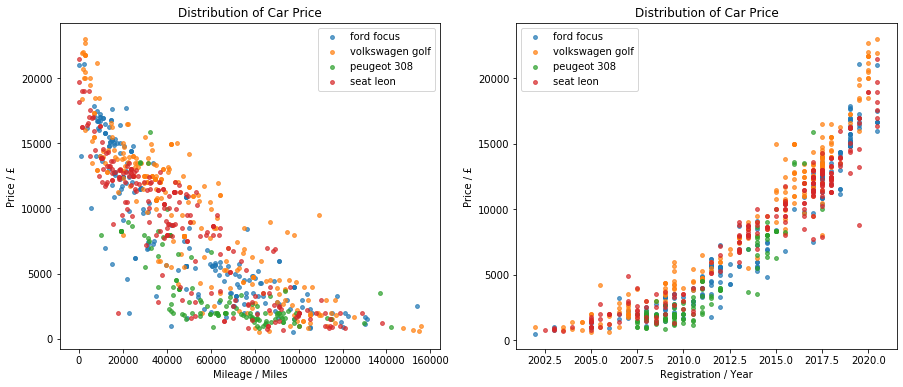

In [22]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

for car_make,car_model in car_makes_models:
    make_model_listings=listings[(listings['make']==car_make) & (listings['model']==car_model)]
    ax[0].scatter(make_model_listings['miles'],
                  make_model_listings['price'],
                  label='{0} {1}'.format(car_make,car_model),
                  s=15,
                  alpha=0.7)
    
    ax[1].scatter(make_model_listings['year'],
                  make_model_listings['price'],
                  label='{0} {1}'.format(car_make,car_model),
                  s=15,
                  alpha=0.7)

ax[0].set_xlabel('Mileage / Miles')
ax[1].set_xlabel('Registration / Year')
for axs in ax:
    axs.legend()
    axs.set_title('Distribution of Car Price')
    axs.set_ylabel('Price / £')

plt.show()

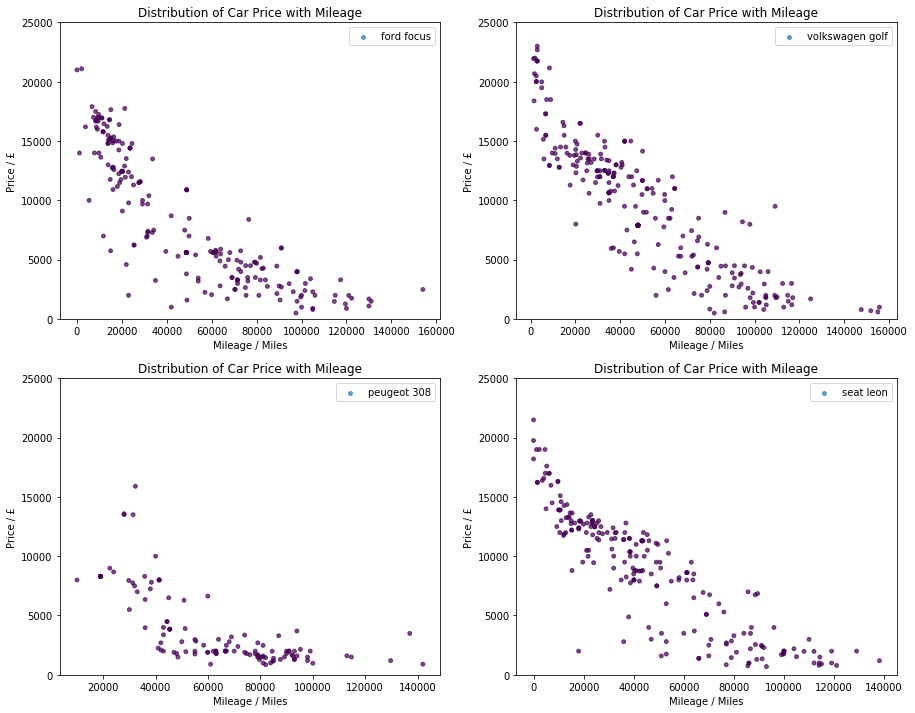

In [103]:
fig, ax = plt.subplots(2,2,figsize=(15,12))

for k,(car_make,car_model) in enumerate(car_makes_models):
    j=int(k%2)
    i=int((k-j)/2)
    make_model_listings=listings[(listings['make']==car_make) & (listings['model']==car_model)]
    ax[i,j].scatter(make_model_listings['miles'],
                    make_model_listings['price'],
                    c=[k for _ in make_model_listings['price']],
                    label='{0} {1}'.format(car_make,car_model),
                    s=15,
                    alpha=0.7)

    ax[i,j].set_xlabel('Mileage / Miles')
    ax[i,j].set_title('Distribution of Car Price with Mileage')
    ax[i,j].set_ylabel('Price / £')
    ax[i,j].set_ylim((0,2.5e4))
    ax[i,j].legend()

plt.show()

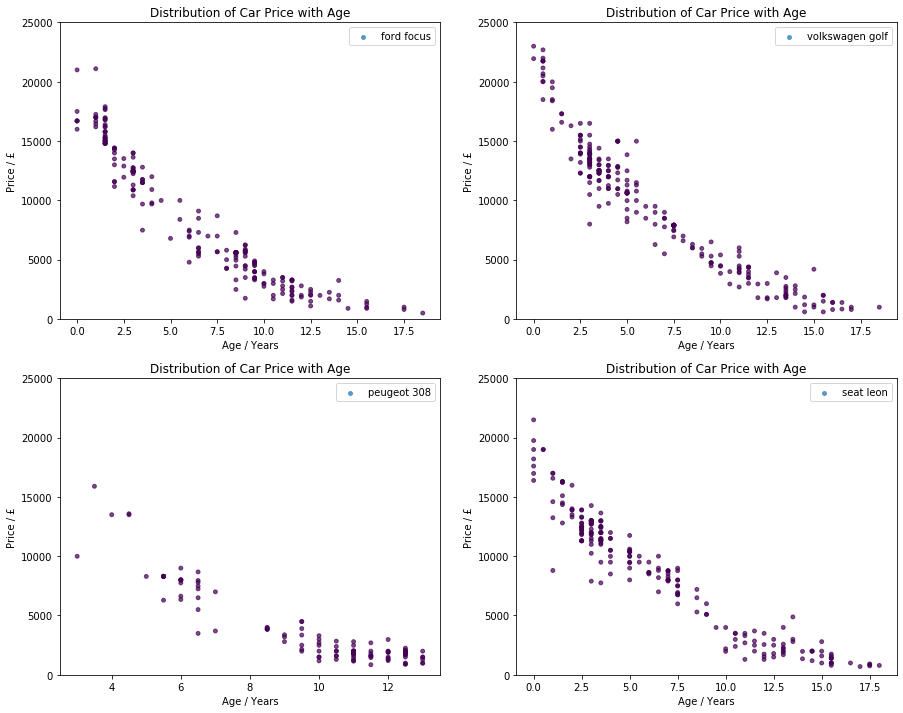

In [104]:
fig, ax = plt.subplots(2,2,figsize=(15,12))

for k,(car_make,car_model) in enumerate(car_makes_models):
    j=int(k%2)
    i=int((k-j)/2)
    make_model_listings=listings[(listings['make']==car_make) & (listings['model']==car_model)]
    ax[i,j].scatter(make_model_listings['age'],
                    make_model_listings['price'],
                    c=[k for _ in make_model_listings['price']],
                    label='{0} {1}'.format(car_make,car_model),
                    s=15,
                    alpha=0.7)

    ax[i,j].set_xlabel('Age / Years')
    ax[i,j].set_title('Distribution of Car Price with Age')
    ax[i,j].set_ylabel('Price / £')
    ax[i,j].set_ylim((0,2.5e4))
    ax[i,j].legend()

plt.show()

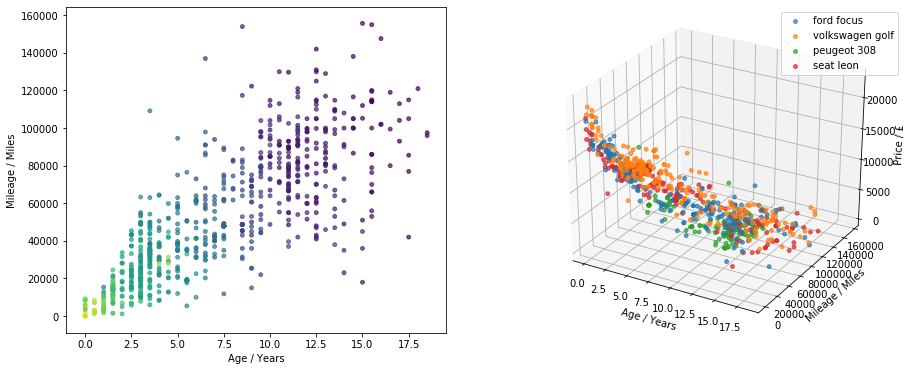

In [105]:
fig = plt.figure(figsize=(15,6))
ax = [fig.add_subplot(121),fig.add_subplot(122, projection='3d')]
      


for car_make,car_model in car_makes_models:
    make_model_listings=listings[(listings['make']==car_make) & (listings['model']==car_model)]
    ax[0].scatter(make_model_listings['age'],
                make_model_listings['miles'],
                c=make_model_listings['price'],
                label='{0} {1}'.format(car_make,car_model),
                s=15,
                alpha=0.7)

    ax[1].scatter(make_model_listings['age'],
               make_model_listings['miles'],
               make_model_listings['price'],
               label='{0} {1}'.format(car_make,car_model),
               s=15,
               alpha=0.7)

for i,axs in enumerate(ax):
    axs.set_xlabel('Age / Years')
    axs.set_ylabel('Mileage / Miles')
    if i==1:
        axs.set_zlabel('Price / £')
        
ax[1].legend()
plt.show()

In [63]:
listings[listings['age']>0].describe()

,price,year,miles,age,engine,power,miles_per_year
count,770.000000,770.000000,769.000000,770.000000,770.00000,761.000000,769.000000
mean,8026.754545,2013.324026,51876.648895,7.175974,1.48961,124.990830,7745.110190
std,5225.680862,4.382093,32776.360408,4.382093,0.09049,23.144428,3365.875614
min,500.000000,2002.000000,1147.000000,0.500000,1.40000,73.000000,573.500000
25%,2950.000000,2009.500000,23663.000000,3.000000,1.40000,113.000000,5712.142857
50%,7900.000000,2014.000000,47390.000000,6.500000,1.50000,123.000000,7300.000000
75%,12450.000000,2017.500000,76945.000000,11.000000,1.60000,138.000000,9318.181818
max,22695.000000,2020.000000,155700.000000,18.500000,1.60000,270.000000,31180.000000


C:\Users\Mille\.julia\conda\3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Mille\.julia\conda\3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


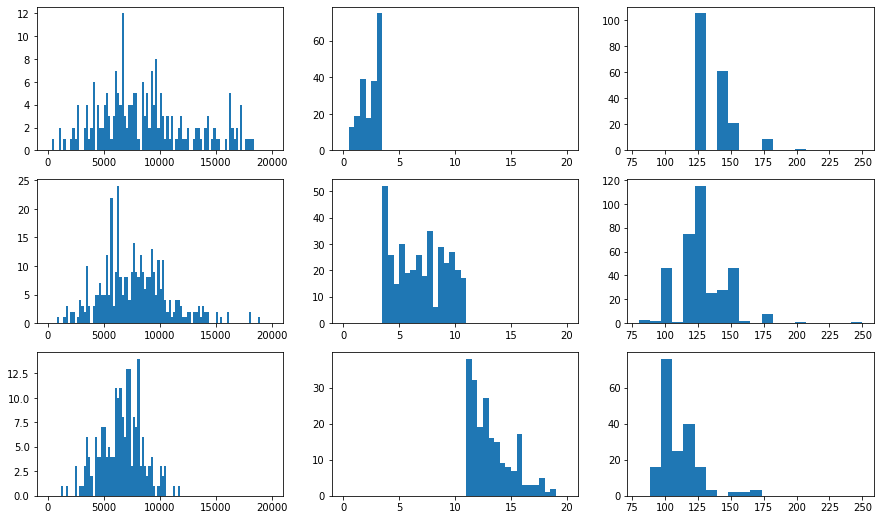

In [77]:
fig, ax = plt.subplots(3,3,figsize=(15,9))

for i,bracket in enumerate(['is_used_newer','is_used_medium','is_used_older']):
    ax[i,0].hist(listings[listings[bracket]]['miles_per_year'],bins=100,range=(0,20000))
    ax[i,1].hist(listings[listings[bracket]]['age'],bins=40,range=(0,20))
    ax[i,2].hist(listings[listings[bracket]]['power'],bins=20,range=(80,250))

plt.show()

#  Simple Regressions

Exclude Peugeot 308 except in older set due to lack of datapoints

In [96]:

complete_makes_models = [(make,model) for make,model in car_makes_models if make!='peugeot']

features=['make','model','is_used_newer','is_used_medium','is_used_older',
          'age','miles','price','engine','power','power_above_med','miles_per_year','miles_per_year_above_med']\
            +['is_{0}_{1}'.format(make,model) for make,model in complete_makes_models]

complete_listings=listings[(listings['make']!='peugeot') | listings['is_used_older']][features].dropna()

complete_listings.describe()

,age,miles,price,engine,power,power_above_med,miles_per_year,miles_per_year_above_med
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,7.021770,51044.418539,8416.029494,1.481882,124.159216,-0.840784,inf,inf
std,4.596506,33502.714963,5468.302394,0.087602,20.547330,20.547330,NaN,NaN
min,0.000000,5.000000,500.000000,1.400000,73.000000,-52.000000,573.500000,-6926.500000
25%,3.000000,22009.000000,2983.000000,1.400000,113.000000,-12.000000,5732.588235,-1767.411765
50%,6.500000,47512.500000,8097.500000,1.500000,123.000000,-2.000000,7425.535714,-74.464286
75%,11.000000,76365.250000,12541.250000,1.600000,138.500000,13.500000,9486.284483,1986.284483
max,18.500000,155700.000000,23000.000000,1.600000,180.000000,55.000000,inf,inf


In [12]:

ridge_regression = Ridge(alpha=1.0).fit(complete_listings[['age','miles']],complete_listings[['price']])
print('Coefficients: {0}'.format(ridge_regression.coef_[0]))
print('R2: {0:.3f}'.format(ridge_regression.score(complete_listings[['age','miles']],complete_listings[['price']])))

ridge_regression_inv = Ridge(alpha=1.0).fit(complete_listings[['age','miles']],
                                            np.log(complete_listings[['price']]))
print('Coefficients: {0}'.format(ridge_regression_inv.coef_[0]))
print('R2: {0:.3f}'.format(ridge_regression_inv.score(complete_listings[['age','miles']],
                                                      np.log(complete_listings[['price']]))))

Coefficients: [-1.29109589e+03 -4.99433199e-02]
R2: 0.765
Coefficients: [-9.83699341e-02 -4.56623794e-06]
R2: 0.777


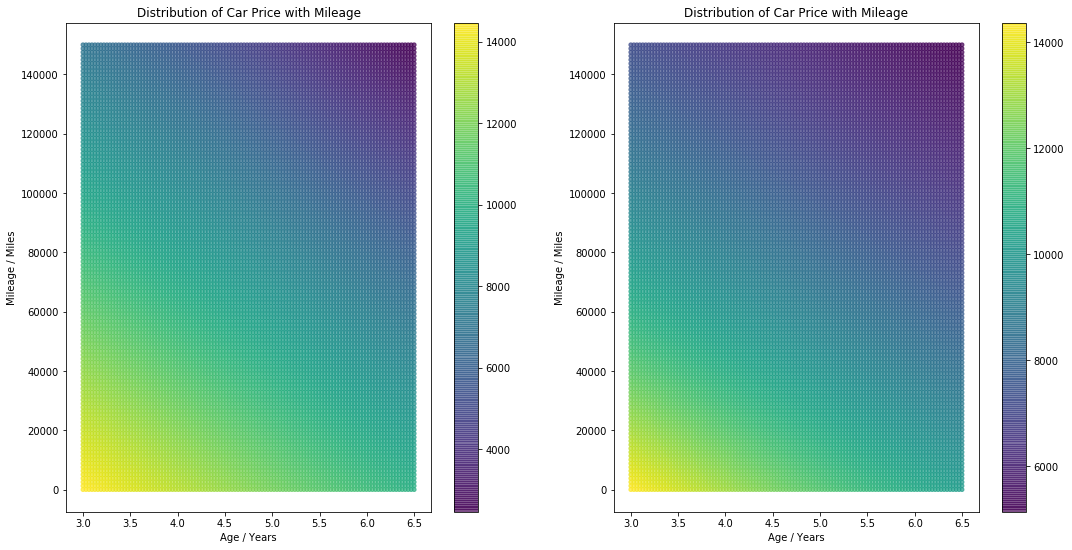

In [13]:
ages, mileages = np.meshgrid(np.linspace(3.0, 6.5, num=112), 
                             np.linspace(0.5, 1.5e5, num=120), sparse=False)

fig, ax = plt.subplots(1,2,figsize=(18,9))

im=ax[0].scatter(ages.flatten(),
                 mileages.flatten(),
                 c=ridge_regression.predict(np.stack([ages.flatten(),mileages.flatten()]).T).flatten(),
                 label='{0} {1}'.format(car_make,car_model),
                 s=15,
                 alpha=0.7)
fig.colorbar(im,ax=ax.ravel()[0])
ax[0].set_title('Distribution of Car Price with Mileage')
ax[0].set_ylabel('Mileage / Miles')
ax[0].set_xlabel('Age / Years')

im=ax[1].scatter(ages.flatten(),
                 mileages.flatten(),
                 c=np.exp(ridge_regression_inv.predict(np.stack([ages.flatten(),mileages.flatten()]).T).flatten()),
                 label='{0} {1}'.format(car_make,car_model),
                 s=15,
                 alpha=0.7)
fig.colorbar(im,ax=ax.ravel()[1])
ax[1].set_title('Distribution of Car Price with Mileage')
ax[1].set_ylabel('Mileage / Miles')
ax[1].set_xlabel('Age / Years')

plt.show()

In [14]:

features=['age','miles']+['is_{0}_{1}'.format(make,model) for make,model in complete_makes_models]
ridge_regression = Ridge(alpha=1.0).fit(complete_listings[features],complete_listings[['price']])
print('Coefficients: {0}'.format(ridge_regression.coef_[0]))
print('R2: {0:.3f}'.format(ridge_regression.score(complete_listings[features],complete_listings[['price']])))

Coefficients: [-1.31020157e+03 -5.43303258e-02 -5.71685640e+02  1.10588641e+03
 -5.34200769e+02]
R2: 0.826


In [15]:

for make,model in complete_makes_models:
    make_model_listings=complete_listings[complete_listings['is_{0}_{1}'.format(make,model)]]
    ridge_regression = Ridge(alpha=1.0).fit(make_model_listings[['age','miles']],make_model_listings[['price']])
    print('{0} {1}:'.format(make,model))
    print('\tCoefficients: {0}'.format(ridge_regression.coef_[0]))
    print('\tR2: {0:.3f}'.format(ridge_regression.score(make_model_listings[['age','miles']],make_model_listings[['price']])))

ford focus:
	Coefficients: [-1.44660393e+03 -5.35164723e-02]
	R2: 0.892
volkswagen golf:
	Coefficients: [-1.52041942e+03 -4.77176820e-02]
	R2: 0.806
seat leon:
	Coefficients: [-9.20392707e+02 -6.57147383e-02]
	R2: 0.795


In [16]:
make_model_listings=complete_listings[complete_listings['is_volkswagen_golf']]

ridge_regression = Ridge(alpha=1.0).fit(make_model_listings[['age','miles','power']],make_model_listings[['price']])
print('Coefficients: {0}'.format({'c_'+k:v for k,v in zip(features,ridge_regression.coef_[0])}))
print('R2: {0:.3f}'.format(ridge_regression.score(make_model_listings[['age','miles','power']],make_model_listings[['price']])))

Coefficients: {'c_age': -1241.238083968519, 'c_miles': -0.04938243088329546, 'c_is_ford_focus': 112.14351094533176}
R2: 0.894


In [17]:

features = ['age','miles','power']+['is_{0}_{1}'.format(make,model) for make,model in complete_makes_models]
ridge_regression = Ridge(alpha=1.0).fit(complete_listings[features],complete_listings[['price']])
print('Coefficients: {0}'.format({'c_'+k:v for k,v in zip(features,ridge_regression.coef_[0])}))
print('R2: {0:.3f}'.format(ridge_regression.score(complete_listings[features],complete_listings[['price']])))

Coefficients: {'c_age': -1244.1139735761788, 'c_miles': -0.05567256112178296, 'c_power': 43.93514567289002, 'c_is_ford_focus': -1046.7359257209546, 'c_is_volkswagen_golf': 1495.3922480646995, 'c_is_seat_leon': -448.65632234425635}
R2: 0.860


In [18]:
# complete_listings=listings[['age','miles','price','is_ford_focus','is_volkswagen_golf','is_peugeot_308']].dropna()
features = ['age','miles','power']
for make,model in complete_makes_models:
    make_model_listings=complete_listings[complete_listings['is_{0}_{1}'.format(make,model)]]
    ridge_regression = Ridge(alpha=1.0).fit(make_model_listings[features],make_model_listings[['price']])
    print('{0} {1}:'.format(make,model))
    print('\tCoefficients: {0}'.format({'c_'+k:v for k,v in zip(features,ridge_regression.coef_[0])}))
    print('\tR2: {0:.3f}'.format(ridge_regression.score(make_model_listings[features],make_model_listings[['price']])))

ford focus:
	Coefficients: {'c_age': -1376.904977546206, 'c_miles': -0.05197261313779449, 'c_power': 21.509706040835674}
	R2: 0.904
volkswagen golf:
	Coefficients: {'c_age': -1241.238083968519, 'c_miles': -0.04938243088329546, 'c_power': 112.14351094533176}
	R2: 0.894
seat leon:
	Coefficients: {'c_age': -972.2274115113703, 'c_miles': -0.07160459010183708, 'c_power': 37.29019209013187}
	R2: 0.816



\begin{align}
    {SE}_{c_i} &= \frac{\sigma_{c_i}}{\sqrt{n}} \\
    c & d
\end{align}

# Statistical Measures


## Age, Mileage, and Power

In [97]:
car_lm = ols('price ~ age + miles_per_year_above_med + power_above_med', 
             data=complete_listings[(complete_listings['is_used_newer'])]).fit()
display(car_lm.summary())
# display(anova_lm(car_lm))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     161.0
Date:                Mon, 26 Oct 2020   Prob (F-statistic):           3.61e-52
Time:                        13:31:59   Log-Likelihood:                -1702.4
No. Observations:                 196   AIC:                             3413.
Df Residuals:                     192   BIC:                             3426.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 1.964e+04    319.980     61.385      0.000     1.9e+04    2.03e+04
age                      -2400.4173    127.901    -18.768      0.000   -2652.689   -2148.146
miles_per_year_above_med    -0.1861      0.025     -7.491      0.000      -0.235      -0.137
power_above_med             13.6008      7.145      1.904      0.058      -0.491      27.693
==============================================================================
Omnibus:                       23.601   Durbin-Watson:                   1.241
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.737
Skew:                          -0.385   Prob(JB):                     2.17e-17
Kurtosis:                       5.967   Cond. No.                     1.44e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [98]:
car_lm = ols('price ~ age + miles_per_year_above_med + power_above_med', 
             data=complete_listings[(complete_listings['is_used_medium'])]).fit()
display(car_lm.summary())
# display(anova_lm(car_lm))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     722.4
Date:                Mon, 26 Oct 2020   Prob (F-statistic):          2.88e-135
Time:                        13:32:13   Log-Likelihood:                -2506.7
No. Observations:                 298   AIC:                             5021.
Df Residuals:                     294   BIC:                             5036.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 1.672e+04    223.619     74.770      0.000    1.63e+04    1.72e+04
age                      -1283.5739     32.296    -39.744      0.000   -1347.135   -1220.013
miles_per_year_above_med    -0.1889      0.019     -9.740      0.000      -0.227      -0.151
power_above_med             12.2998      3.951      3.113      0.002       4.523      20.076
==============================================================================
Omnibus:                       24.289   Durbin-Watson:                   1.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.870
Skew:                          -0.015   Prob(JB):                     1.52e-21
Kurtosis:                       5.779   Cond. No.                     1.20e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [99]:
car_lm = ols('price ~ age + miles_per_year_above_med + power_above_med', 
             data=complete_listings[complete_listings['is_used_older']]).fit()
display(car_lm.summary())
# display(anova_lm(car_lm))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     36.54
Date:                Mon, 26 Oct 2020   Prob (F-statistic):           7.41e-19
Time:                        13:32:15   Log-Likelihood:                -1648.5
No. Observations:                 203   AIC:                             3305.
Df Residuals:                     199   BIC:                             3318.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 6024.3358    413.235     14.578      0.000    5209.454    6839.218
age                       -311.3048     32.780     -9.497      0.000    -375.945    -246.665
miles_per_year_above_med    -0.1714      0.031     -5.478      0.000      -0.233      -0.110
power_above_med              2.1915      3.452      0.635      0.526      -4.615       8.998
==============================================================================
Omnibus:                       25.168   Durbin-Watson:                   0.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.030
Skew:                           0.848   Prob(JB):                     1.83e-07
Kurtosis:                       3.890   Cond. No.                     1.52e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Summary
> Age, mileage, and power become much less important in year<2010 cars, describing only 35% of variance instead of 70% or 80%

> Power appears to be a significant variable only in more recent cars

> General schedule of depreciation:

year | Depreciation
--- | ---
2017+ | £2400 per year
2010-2017 | £1283 per year
<2010 | £311 per year

## Make and age, mileage, and power

In [152]:
car_lm = ols('price ~ age*C(make) + miles_per_year_above_med + power_above_med', 
             data=complete_listings[(complete_listings['is_used_newer'])]).fit()
display(car_lm.summary())
# display(anova_lm(car_lm0
car_lm_newer = car_lm

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     148.6
Date:                Mon, 26 Oct 2020   Prob (F-statistic):           4.27e-73
Time:                        17:32:16   Log-Likelihood:                -1641.7
No. Observations:                 196   AIC:                             3299.
Df Residuals:                     188   BIC:                             3326.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  1.882e+04    437.106     43.046      0.000     1.8e+04    1.97e+04
C(make)[T.seat]           -1480.9230    636.236     -2.328      0.021   -2736.002    -225.844
C(make)[T.volkswagen]      2224.3518    518.785      4.288      0.000    1200.964    3247.739
age                       -2632.9871    175.575    -14.996      0.000   -2979.338   -2286.637
age:C(make)[T.seat]         859.7301    259.222      3.317      0.001     348.372    1371.088
age:C(make)[T.volkswagen]    81.3148    230.636      0.353      0.725    -373.653     536.283
miles_per_year_above_med     -0.1861      0.019     -9.879      0.000      -0.223      -0.149
power_above_med              44.2474      8.215      5.386      0.000      28.042      60.453
==============================================================================
Omnibus:                       92.018   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              485.248
Skew:                          -1.744   Prob(JB):                    4.26e-106
Kurtosis:                       9.874   Cond. No.                     4.92e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.92e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [126]:
car_lm = ols('price ~ age*C(make) + miles_per_year_above_med + power_above_med', 
             data=complete_listings[(complete_listings['is_used_medium'])]).fit()
display(car_lm.summary())
# display(anova_lm(car_lm))
car_lm_medium = car_lm

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     706.4
Date:                Mon, 26 Oct 2020   Prob (F-statistic):          4.38e-178
Time:                        14:37:22   Log-Likelihood:                -2392.2
No. Observations:                 298   AIC:                             4800.
Df Residuals:                     290   BIC:                             4830.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  1.292e+04    336.338     38.426      0.000    1.23e+04    1.36e+04
C(make)[T.seat]            2454.5270    389.211      6.306      0.000    1688.490    3220.564
C(make)[T.volkswagen]      4942.6500    393.658     12.556      0.000    4167.860    5717.440
age                        -884.3235     43.095    -20.520      0.000    -969.142    -799.505
age:C(make)[T.seat]        -235.5211     54.471     -4.324      0.000    -342.730    -128.312
age:C(make)[T.volkswagen]  -450.1871     53.491     -8.416      0.000    -555.468    -344.906
miles_per_year_above_med     -0.2150      0.013    -16.024      0.000      -0.241      -0.189
power_above_med              28.3276      3.017      9.390      0.000      22.390      34.265
==============================================================================
Omnibus:                       44.166   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              351.466
Skew:                          -0.182   Prob(JB):                     4.79e-77
Kurtosis:                       8.308   Cond. No.                     4.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [157]:
car_lm = ols('price ~ age*C(make) + miles_per_year_above_med + power_above_med', 
             data=complete_listings[(complete_listings['is_used_older'])]).fit()
display(car_lm.summary())
# display(anova_lm(car_lm))
car_lm_older = car_lm

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     64.68
Date:                Mon, 26 Oct 2020   Prob (F-statistic):           1.65e-53
Time:                        17:33:59   Log-Likelihood:                -1552.0
No. Observations:                 203   AIC:                             3124.
Df Residuals:                     193   BIC:                             3157.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  7117.3183    548.484     12.976      0.000    6035.525    8199.111
C(make)[T.peugeot]        -2136.3445   1295.599     -1.649      0.101   -4691.695     419.006
C(make)[T.seat]             124.1914    764.632      0.162      0.871   -1383.917    1632.300
C(make)[T.volkswagen]      3430.4846    735.725      4.663      0.000    1979.391    4881.578
age                        -399.5297     42.346     -9.435      0.000    -483.049    -316.010
age:C(make)[T.peugeot]      102.4770    108.318      0.946      0.345    -111.161     316.115
age:C(make)[T.seat]           4.1490     56.700      0.073      0.942    -107.682     115.980
age:C(make)[T.volkswagen]  -198.6027     55.316     -3.590      0.000    -307.705     -89.501
miles_per_year_above_med     -0.2390      0.020    -11.728      0.000      -0.279      -0.199
power_above_med               2.4322      2.391      1.017      0.310      -2.283       7.148
==============================================================================
Omnibus:                        6.695   Durbin-Watson:                   1.657
Prob(Omnibus):                  0.035   Jarque-Bera (JB):               10.045
Skew:                           0.136   Prob(JB):                      0.00659
Kurtosis:                       4.055   Cond. No.                     8.12e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Summary

> Adding age with dummy variable by make massively improves the amount of variance explained by all models

> Additional costs per 10HP above 125HP

year | Additional Costs
--- | ---
2017+ | £440 per 10HP
2010-2017 | £280 per 10HP
<2010 | £230 per 10HP


> Make-specific schedule of depreciation (approximate):

year | Ford Focus | Peugeot 308 | Seat Leon | Volkswagen Golf 
--- | --- | --- | --- | ---
2017+ | £2630 / yr | - | £1770 / yr | £2600 / yr
2010-2017 | £885 / yr | - | £1120 / yr | £1335 / yr
<2010 | £400 / yr | £300 / yr | £400 / yr | £600 / yr

> Make-specific base price (approximate):

year | Ford Focus | Peugeot 308 | Seat Leon | Volkswagen Golf 
--- | --- | --- | --- | ---
2017+ | £18820 | - | £17360 | £21040
2010-2017 | £12920 | - | £15370 | £15860
<2010 | £7120 | £4990  | £7240 | £10550

## Age, make x mileage, and power

In [50]:
car_lm = ols('price ~ age + miles_per_year*C(make) + power', 
             data=complete_listings[(complete_listings['is_used_newer'])]).fit()
display(car_lm.summary())
# display(anova_lm(car_lm))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     140.0
Date:                Mon, 26 Oct 2020   Prob (F-statistic):           4.80e-71
Time:                        12:52:04   Log-Likelihood:                -1646.6
No. Observations:                 196   AIC:                             3309.
Df Residuals:                     188   BIC:                             3335.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             1.265e+04   1413.977      8.948      0.000    9862.505    1.54e+04
C(make)[T.seat]                       1268.5673    542.143      2.340      0.020     199.102    2338.032
C(make)[T.volkswagen]                 2573.6351    539.403      4.771      0.000    1509.574    3637.696
age                                  -2365.1725     99.934    -23.667      0.000   -2562.308   -2168.037
miles_per_year                          -0.1463      0.039     -3.736      0.000      -0.224      -0.069
miles_per_year:C(make)[T.seat]          -0.0778      0.050     -1.558      0.121      -0.176       0.021
miles_per_year:C(make)[T.volkswagen]    -0.0043      0.051     -0.085      0.932      -0.105       0.096
power                                   51.6842      8.235      6.276      0.000      35.439      67.930
==============================================================================
Omnibus:                       94.287   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              525.160
Skew:                          -1.773   Prob(JB):                    9.18e-115
Kurtosis:                      10.192   Cond. No.                     2.06e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
car_lm = ols('price ~ age + miles_per_year*C(make) + power', 
             data=complete_listings[(complete_listings['is_used_newer'])]).fit()
display(car_lm.summary())
# display(anova_lm(car_lm))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     591.0
Date:                Mon, 26 Oct 2020   Prob (F-statistic):          1.53e-167
Time:                        12:49:47   Log-Likelihood:                -2417.2
No. Observations:                 298   AIC:                             4850.
Df Residuals:                     290   BIC:                             4880.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             1.424e+04    558.628     25.496      0.000    1.31e+04    1.53e+04
C(make)[T.seat]                        495.1870    345.895      1.432      0.153    -185.596    1175.970
C(make)[T.volkswagen]                  810.9593    293.566      2.762      0.006     233.168    1388.750
age                                  -1145.0881     25.761    -44.450      0.000   -1195.791   -1094.385
miles_per_year                          -0.2697      0.027     -9.822      0.000      -0.324      -0.216
miles_per_year:C(make)[T.seat]           0.0283      0.041      0.686      0.494      -0.053       0.109
miles_per_year:C(make)[T.volkswagen]     0.1239      0.034      3.616      0.000       0.056       0.191
power                                   21.5610      3.153      6.838      0.000      15.355      27.767
==============================================================================
Omnibus:                       38.560   Durbin-Watson:                   1.708
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              267.715
Skew:                           0.076   Prob(JB):                     7.35e-59
Kurtosis:                       7.641   Cond. No.                     1.23e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [102]:
for make,model in car_makes_models:
    complete_listings['age_{0}_{1}'.format(make, model)]=complete_listings['age']*complete_listings['is_{0}_{1}'.format(make, model)]

car_lm = ols('price ~ miles_per_year + power + '+' + '.join(['age_{0}_{1}'.format(make, model) for make,model in car_makes_models]), 
             data=complete_listings[(complete_listings['age']>0.) & (complete_listings['age']<=3.)]).fit()
display(car_lm.summary())
display(anova_lm(car_lm))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     136.1
Date:                Sat, 24 Oct 2020   Prob (F-statistic):           5.00e-66
Time:                        10:53:12   Log-Likelihood:                -1671.5
No. Observations:                 197   AIC:                             3357.
Df Residuals:                     190   BIC:                             3380.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1.416e+04   1214.342     11.661      0.000    1.18e+04    1.66e+04
miles_per_year         -0.1934      0.021     -9.432      0.000      -0.234      -0.153
power                  52.6456      8.503      6.191      0.000      35.872      69.419
age_ford_focus      -2935.9681    133.811    -21.941      0.000   -3199.914   -2672.022
age_volkswagen_golf -1891.6299    118.023    -16.028      0.000   -2124.433   -1658.827
age_peugeot_308     -4126.7154    447.046     -9.231      0.000   -5008.526   -3244.905
age_seat_leon       -2560.7424    120.882    -21.184      0.000   -2799.185   -2322.300
==============================================================================
Omnibus:                       83.328   Durbin-Watson:                   1.694
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              499.214
Skew:                          -1.484   Prob(JB):                    3.95e-109
Kurtosis:                      10.211   Cond. No.                     1.40e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,df,sum_sq,mean_sq,F,PR(>F)
miles_per_year,1.0,2.220707e+08,2.220707e+08,156.086289,1.553334e-26
power,1.0,4.083105e+07,4.083105e+07,28.698823,2.428229e-07
age_ford_focus,1.0,1.549537e+08,1.549537e+08,108.911947,1.915780e-20
age_volkswagen_golf,1.0,1.188623e+06,1.188623e+06,0.835445,3.618613e-01
age_peugeot_308,1.0,1.042861e+08,1.042861e+08,73.299289,3.739893e-15
age_seat_leon,1.0,6.384653e+08,6.384653e+08,448.756541,6.492836e-52
Residual,190.0,2.703212e+08,1.422743e+06,NaN,NaN


# Issues with this so far?

1. Age and Mileage correlate *strongly*, making most anova-style statistical analysis invalid

Let's assume multiplicative, not additive, by regressing log of price against the logs of the features:

In [462]:
# complete_listings=listings[['age','miles','price','is_ford_focus','is_volkswagen_golf','is_peugeot_308']].dropna()

features=['age','miles_per_year','power']#+['is_{0}_{1}'.format(make,model) for make,model in car_makes_models]
ridge_regression = Ridge(alpha=1.0).fit(complete_listings[features],complete_listings[['price']])
print('Coefficients: {0}'.format(ridge_regression.coef_[0]))
print('R2: {0:.3f}'.format(ridge_regression.score(complete_listings[features],complete_listings[['price']])))

Coefficients: [-1.53639578e+03 -1.49270757e-01  9.56094572e+00]
R2: 0.666


In [463]:
# complete_listings=listings[['age','miles','price','is_ford_focus','is_volkswagen_golf','is_peugeot_308']].dropna()
features = ['age','miles_per_year','power']
for make,model in car_makes_models:
    make_model_listings=complete_listings[complete_listings['is_{0}_{1}'.format(make,model)]]
    ridge_regression = Ridge(alpha=1.).fit(make_model_listings[features],make_model_listings[['price']])
    print('{0} {1}:'.format(make,model))
    print('\tCoefficients: {0}'.format({'c_'+k:v for k,v in zip(features,ridge_regression.coef_[0])}))
    print('\tIntercept: {0}'.format(ridge_regression.intercept_[0]))
    print('\tR2: {0:.3f}'.format(ridge_regression.score(make_model_listings[features],make_model_listings[['price']])))

ford focus:
	Coefficients: {'c_age': -1399.600864444183, 'c_miles_per_year': -0.23994100728624096, 'c_power': 23.950879577011037}
	Intercept: 14482.172689503534
	R2: 0.945
volkswagen golf:
	Coefficients: {'c_age': -1253.2363175200321, 'c_miles_per_year': -0.17069775290601708, 'c_power': 103.42953669266515}
	Intercept: 5706.515133879197
	R2: 0.770
peugeot 308:
	Coefficients: {'c_age': -473.65283378782703, 'c_miles_per_year': -0.17191328489273883, 'c_power': 45.40270210404401}
	Intercept: 4892.341188559994
	R2: 0.893
seat leon:
	Coefficients: {'c_age': -1197.8983127968995, 'c_miles_per_year': -0.22328352890877723, 'c_power': 20.83047322947627}
	Intercept: 14909.053968514687
	R2: 0.766


In [472]:

for (make,model),group in listings.groupby(['make','model']):
    markdown('# {0} {1}'.format(make,model))
    display(group.describe())
# complete_listings[complete_listings['is_peugeot_308']][['age','miles','miles_per_year','power']].describe()

# ford focus

,price,year,miles,age,engine,power,miles_per_year
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,10170.788462,2016.288462,33250.519231,4.211538,1.526923,143.528654,7729.186777
std,2661.242871,1.425765,21240.279027,1.425765,0.044789,25.000125,3626.629379
min,4789.000000,2014.000000,5432.000000,3.000000,1.500000,84.000000,987.636364
25%,7493.750000,2014.500000,20014.000000,3.000000,1.500000,147.900000,5391.928571
50%,10902.500000,2017.000000,24780.000000,3.500000,1.500000,147.900000,6716.000000
75%,12450.000000,2017.500000,48872.000000,6.000000,1.600000,148.000000,9250.000000
max,14000.000000,2017.500000,91000.000000,6.500000,1.600000,180.000000,16290.666667


# peugeot 308

,price,year,miles,age,engine,power,miles_per_year
count,31.000000,31.000000,31.000000,31.000000,3.100000e+01,31.000000,31.000000
mean,8510.322581,2014.887097,34064.645161,5.612903,1.600000e+00,161.645161,6180.896343
std,2512.536957,0.901015,22114.866669,0.901015,4.514300e-16,44.289614,3699.194172
min,3490.000000,2014.000000,10000.000000,3.000000,1.600000e+00,125.000000,1666.666667
25%,7620.000000,2014.250000,18965.000000,5.500000,1.600000e+00,125.000000,3448.181818
50%,8299.000000,2014.500000,31266.000000,6.000000,1.600000e+00,156.000000,5846.153846
75%,8300.000000,2015.000000,39200.000000,6.250000,1.600000e+00,156.000000,6952.649573
max,15895.000000,2017.500000,137000.000000,6.500000,1.600000e+00,270.000000,21076.923077


# seat leon

,price,year,miles,age,engine,power,miles_per_year
count,79.000000,77.000000,79.000000,77.000000,79.000000,77.000000,77.000000
mean,11053.658228,2016.448052,34193.367089,4.051948,1.402532,139.470130,8649.515246
std,1657.952467,1.119752,15736.171828,1.119752,0.022502,11.477057,3663.480953
min,6995.000000,2014.000000,9294.000000,3.000000,1.400000,123.000000,2396.800000
25%,9992.500000,2015.500000,22454.500000,3.000000,1.400000,123.250000,6189.666667
50%,11400.000000,2017.000000,32567.000000,3.500000,1.400000,147.900000,7876.333333
75%,12442.500000,2017.500000,44046.500000,5.000000,1.400000,148.000000,10413.714286
max,14270.000000,2017.500000,85679.000000,6.500000,1.600000,150.000000,18333.333333


# volkswagen golf

,price,year,miles,age,engine,power,miles_per_year
count,104.000000,103.000000,104.000000,103.000000,104.000000,102.000000,103.000000
mean,12076.067308,2016.451456,37024.048077,4.048544,1.405769,125.427745,9306.879497
std,1854.738158,0.991420,18854.894635,0.991420,0.027260,8.330795,4405.867665
min,6275.000000,2014.000000,6006.000000,3.000000,1.400000,114.000000,1716.000000
25%,10932.500000,2015.500000,25265.250000,3.000000,1.400000,123.000000,6719.500000
50%,12300.000000,2016.500000,34834.000000,4.000000,1.400000,123.000000,9231.500000
75%,13362.750000,2017.500000,45347.500000,5.000000,1.400000,123.250000,10926.728571
max,16495.000000,2017.500000,109130.000000,6.500000,1.600000,148.000000,31180.000000


In [439]:
# complete_listings=listings[['age','miles','price','is_ford_focus','is_volkswagen_golf','is_peugeot_308']].dropna()

features=['age','miles_per_year','power']#+['is_{0}_{1}'.format(make,model) for make,model in car_makes_models]
ridge_regression = Ridge(alpha=1.0).fit(np.log(complete_listings[features]),np.log(complete_listings[['price']]))
print('Coefficients: {0}'.format(ridge_regression.coef_[0]))
print('R2: {0:.3f}'.format(ridge_regression.score(np.log(complete_listings[features]),np.log(complete_listings[['price']]))))

Coefficients: [-0.64237045 -0.10844016  0.14813871]
R2: 0.614


In [481]:
# complete_listings=listings[['age','miles','price','is_ford_focus','is_volkswagen_golf','is_peugeot_308']].dropna()
features = ['age','miles_per_year','power']
for make,model in car_makes_models:
    make_model_listings=complete_listings[complete_listings['is_{0}_{1}'.format(make,model)]]
    ridge_regression = Ridge(alpha=1.0).fit(np.log(make_model_listings[features]),
                                            np.log(make_model_listings[['price']]))
    markdown('#### {0} {1}:'.format(make,model))
    print('\tCoefficients: {0}'.format({'c_'+k:v for k,v in zip(features,ridge_regression.coef_[0])}))
    print('\tR2: {0:.3f}\n'.format(ridge_regression.score(np.log(make_model_listings[features]),
                                                        np.log(make_model_listings[['price']]))))

#### ford focus:

	Coefficients: {'c_age': -0.6080600225945364, 'c_miles_per_year': -0.17994670490318307, 'c_power': 0.2913823447769028}
	R2: 0.922



#### volkswagen golf:

	Coefficients: {'c_age': -0.3851350018532487, 'c_miles_per_year': -0.11160441717714231, 'c_power': 0.3110342244082285}
	R2: 0.586



#### peugeot 308:

	Coefficients: {'c_age': -0.3396557029061871, 'c_miles_per_year': -0.151542353620689, 'c_power': 0.5152259140834093}
	R2: 0.724



#### seat leon:

	Coefficients: {'c_age': -0.3912244652120891, 'c_miles_per_year': -0.13880565340788237, 'c_power': 0.07672925776851056}
	R2: 0.692



(array([ 2.,  7., 11., 37., 23., 41., 74., 45., 16.,  3.]),
 array([ 3490. ,  4790.5,  6091. ,  7391.5,  8692. ,  9992.5, 11293. ,
        12593.5, 13894. , 15194.5, 16495. ]),
 <a list of 10 Patch objects>)

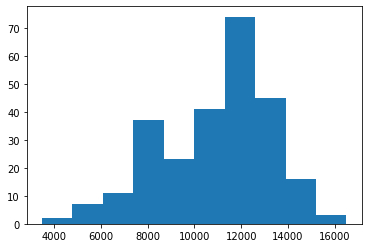

In [366]:
fig = plt.figure()

plt.hist()

# Specific cars

In [123]:
from matplotlib.image import imread

In [147]:
shortlist=[]
with open('./web_pages/ford_focus_shortlist.html') as html_doc:
    soup = BeautifulSoup(html_doc, 'html.parser')
    html_listings = soup.findAll("div", {"class": "product-card__inner"})
    for html_listing in html_listings:
        shortlist.append(format_listing(html_listing,'ford','focus'))

shortlist = pd.DataFrame(shortlist)

shortlist['year']=[float(l.split(' ')[0])+0.5*(int(l.split(' ')[1][1:3])>=50) if l is not None else None for l in shortlist['reg_year']]
shortlist['miles']=[float(l.replace(',','').split(' ')[0]) if l is not None else None for l in shortlist['mileage']]
shortlist['age']=2020.5-listings['year']
shortlist['engine']=[float(l[:-1]) for l in shortlist['engine_size']]

shortlist['power']=[float(l.replace('BHP','').replace('PS',''))*(0.986 if re.search(r'PS',l) else 1.) if l is not None else None for l in shortlist['engine_power']]
print("Median Horse Power {0}".format(shortlist['power'].median()))
shortlist['power_above_med']=shortlist['power']-125

shortlist['miles_per_year']=shortlist['miles']/shortlist['age']
print("Median Miles per year".format(shortlist['miles_per_year'].median()))
shortlist['miles_per_year_above_med']=shortlist['miles_per_year']-7.5e3

shortlist['is_new']=(shortlist['age']==0.)
shortlist['is_used_newer']=(shortlist['year']>2017)&(shortlist['age']>0.)
shortlist['is_used_medium']=(shortlist['year']<=2017)&(shortlist['year']>=2010)
shortlist['is_used_older']=(shortlist['year']<2010)

for car_make,car_model in car_makes_models:
    shortlist['is_{0}_{1}'.format(car_make,car_model)]=(shortlist['make']==car_make) & (shortlist['model']==car_model)
    
shortlist.head()

Median Horse Power 147.9
Median Miles per year


,make,model,thumbnails,price,reg_year,body_type,mileage,engine_size,engine_power,gearbox,...,miles_per_year,miles_per_year_above_med,is_new,is_used_newer,is_used_medium,is_used_older,is_ford_focus,is_volkswagen_golf,is_peugeot_308,is_seat_leon
0,ford,focus,ford_focus_shortlist_files/af3b2316ddd04623b72...,12350,2017 (67 reg),2017 (67 reg),"20,148 miles",1.5L,148BHP,Hatchback,...,6716.000000,-784.000000,False,True,False,False,True,False,False,False
1,ford,focus,ford_focus_shortlist_files/06c9c9c5b54b4544b32...,12250,2017 (67 reg),2017 (67 reg),"18,636 miles",1.5L,150PS,Hatchback,...,6212.000000,-1288.000000,False,True,False,False,True,False,False,False
2,ford,focus,ford_focus_shortlist_files/5111608756314fefbc5...,9790,2016 (66 reg),2016 (66 reg),"23,000 miles",1.5L,150PS,Hatchback,...,4181.818182,-3318.181818,False,False,True,False,True,False,False,False
3,ford,focus,ford_focus_shortlist_files/194ed46308f743ccb8b...,12295,2017 (67 reg),2017 (67 reg),"17,077 miles",1.5L,150PS,Hatchback,...,4879.142857,-2620.857143,False,True,False,False,True,False,False,False
4,ford,focus,ford_focus_shortlist_files/e1ad988972ff48d69ad...,12750,2017 (67 reg),2017 (67 reg),"15,846 miles",1.5L,150PS,Hatchback,...,2437.846154,-5062.153846,False,True,False,False,True,False,False,False


In [154]:

shortlist = shortlist.assign(price_medium_prediction = car_lm_medium.predict(shortlist))
shortlist = shortlist.assign(price_newer_prediction = car_lm_newer.predict(shortlist))


# for car in cars.iterrows():
# #     print(type(car[1]['thumbnails']))
#     for thumbnail in car[1]['thumbnails']: 
#         plt.imshow(imread('./'+thumbnail))
#         plt.show()

In [155]:
cars.columns

Index(['make', 'model', 'thumbnails', 'price', 'reg_year', 'body_type',
       'mileage', 'engine_size', 'engine_power', 'gearbox', 'fuel_type',
       'owners', 'emissions', 'history', 'details', 'doors', 'year', 'miles',
       'age', 'engine', 'power', 'miles_per_year', 'is_new', 'is_used_newer',
       'is_used_older', 'is_ford_focus', 'is_volkswagen_golf',
       'is_peugeot_308', 'is_seat_leon', 'is_used_medium',
       'miles_per_year_above_med', 'power_above_med', 'price_prediction'],
      dtype='object')

In [156]:
shortlist[['price','price_medium_prediction','price_newer_prediction','age','reg_year','mileage','engine_size']]

,price,price_medium_prediction,price_newer_prediction,age,reg_year,mileage,engine_size
0,12350,11091.290037,12080.282573,3.0,2017 (67 reg),"20,148 miles",1.5L
1,12250,11196.828616,12169.657562,3.0,2017 (67 reg),"18,636 miles",1.5L
2,9790,9422.554611,5965.028041,5.5,2016 (66 reg),"23,000 miles",1.5L
3,12295,11041.261135,11101.222806,3.5,2017 (67 reg),"17,077 miles",1.5L
4,12750,8913.224326,3656.612547,6.5,2017 (67 reg),"15,846 miles",1.5L
5,11000,8356.051409,3174.357098,6.5,2017 (67 reg),"32,689 miles",1.5L
6,12499,9288.875211,4915.538294,6.0,2017 (67 reg),"16,483 miles",1.5L
7,9825,8933.027323,3675.725708,6.5,2015 (15 reg),"15,333 miles",1.5L
8,12350,10567.989304,9759.775098,4.0,2017 (67 reg),"20,148 miles",1.5L
9,12425,11262.949666,12228.860849,3.0,2017 (67 reg),"17,753 miles",1.5L
